# Dependecies

In [1]:
from qiskit import *
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.visualization import array_to_latex
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector, random_statevector
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit.library import *
import numpy as np
from numpy.linalg import eig

In [2]:
my_style = {
"backgroundcolor" : "#111111",
"linecolor" : "#FFFFFF",
"textcolor": "#FFFFFF",
"gatetextcolor": "#FFFFFF" }

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum", token="f58f42d85021cfb16a7674da14445e2ac7522ded0081c841dc9a136dfb352cbf416cf00f4988292d7fa182e2029535db74f617df0aeaf9dde978ada62774f469")

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\swch}[3]{\left\langle{#1}\middle| #2 \middle| {#3}\right\rangle}$$

$$\newcommand{\v}[2]{\begin{pmatrix} {#1} \\ #2 \end{pmatrix}}$$

# VQE - Teorie

## Měření v Bázi

Měření obvykle probíhá v určité bázi. Často využívaná báze je tzv. standardní báze:

$$\ket{0} = \v{1}{0}, \quad \ket{1} = \v{0}{1}, \quad \ket{\psi} = a \ket{0} + b \ket{1} $$

Tato báze je mj. tvořena vlastními vektory $\sigma_z$. Měření v bázi odpovídá užití projektorů na podprostor daného bazického vektoru. Tedy měření ve standardní bázi je ekvivalentní užívání projektorů $P_0 = \ket{0}\bra{0}$ a $P_1 = \ket{1}\bra{1}$. 

Pozorovatelné odpovídají Hermitovským operátorům. Jsou tedy diagonalizovatelné a jejich vlastní vektory tvoří kompletní bázi. Měření v bázi, ve které je hermitovský operátor (pozorovatelné) $H$ diagonální (vlastní/přirozená báze) odpovídá měření ve standardní bázi. Abychom tedy mohli provádět měření (ve std. bázi) musíme pozorovatelné diagonalizovat. To lze provést transformací stavu před měřením. 

$$
\begin{align}
\swch{\psi}{H}{\psi} & = \swch{\psi}{X^\dagger VX}{\psi} \\
  & = 
\end{align}
$$

Měření pozorovatelné $H$ na stavu $\ket{\psi}$ tedy odpovídá měření pozorovatelné $H$ ve stavu $X\ket{\psi}$ **ve standardní bázi**, tj užití operátorů $P_0 = \ket{0}\bra{0}$ a $P_1 = \ket{1}\bra{1}$.

Na problém měření lze také nahlédnout alternativně. Máme-li pozorovatelnou (obvod), pak můžeme měřit pouze vlastní stavy či jejich superpozici (respektive projekci na některý z těchto stavů, do kterého nám následně systém zkolabuje). Abychom mohli tedy měřit v jiné bázi, než v bázi vlastní daného obvodu, musíme obvod modifikovat tak, aby vlastní stavy určitým způsobem korespondovaly s naší měřící bazí. Tedy chceme, aby projekční měření modifikovaného obvodu na jednotlivé vektory zvolené měřící báze odpovídalo projekčnímu měření nemodifikovaného obvodu na jeho vlastní stavy.

Toho lze docílit snadno tak, že do obvodu přidáme jakousi "měřící část", která mapuje vlastní stavy obvodu na vektory měřící báze. Tento přidaný měřící obvod odpovídá inverzi obvodu, který z měřící báze vytvoří vlastní stavy

Často také říkáme, že pro měření provedeme rotaci do Z báze. Z báze představuje standartní bázi (vl. vektory $\sigma_z$).

### Příklad (měření x v x-bázi)

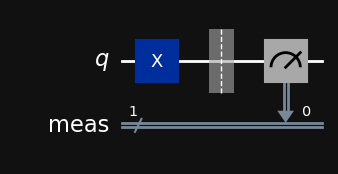

In [93]:
qc_1 = QuantumCircuit(1)
qc_1.x(0)
qc_1.measure_all()
qc_1.draw('mpl', style = my_style)

In [94]:
sampler = Sampler()
job_1 = sampler.run(qc_1)
job_1.result().quasi_dists

[{1: 1.0}]

Provedeme rotaci do X báze. Tato báze je tvořena vektory $\ket{+}$ a $\ket{-}$, kzeré lze ze standardní báze $\ket{0}$, $\ket{1}$ získat aplikací Hadamardova operátoru H. Rotaci do X báze tedy provedeme aplikací inverzního operátoru H$^{-1}$= H

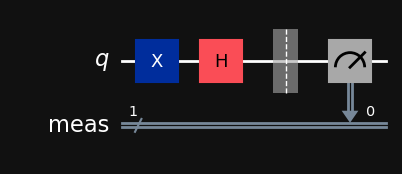

In [95]:
qc_1.remove_final_measurements()
qc_1.h(0)
qc_1.measure_all()
qc_1.draw('mpl', style = my_style)

In [96]:
sampler = Sampler()
job_1 = sampler.run(qc_1)
job_1.result().quasi_dists

[{0: 0.5, 1: 0.5}]

Měříme v X bázi a tedy výsledný vektor má tvar $\tfrac{1}{2}\ket{+} - \tfrac{1}{2}\ket{-}$ = $\ket{1}$

### Příklad (měření v bellově bázi)

Chceme provádět měření v bellově bází $\ket{\psi^{ij}}$:

$$ \ket{\psi^{00}} = \tfrac{1}{\sqrt{2}}(\ket{00}+\ket{11}) $$
$$ \ket{\psi^{01}} = \tfrac{1}{\sqrt{2}}(\ket{01}+\ket{10}) $$
$$ \ket{\psi^{10}} = \tfrac{1}{\sqrt{2}}(\ket{00}+\ket{11}) $$
$$ \ket{\psi^{11}} = \tfrac{1}{\sqrt{2}}(\ket{01}-\ket{10}) $$

Tyto stavy lze z standartní báze ($\ket{00}$, $\ket{01}$, $\ket{10}$, $\ket{11}$) vytvořit následujícím obvodem:

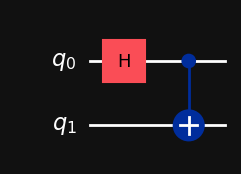

In [46]:
bellcircuit = QuantumCircuit(2)
bellcircuit.h(0)
bellcircuit.cx(0,1)
bellcircuit.draw("mpl", style=my_style)

In [27]:
bell_op = Operator(bellcircuit)
#array_to_latex(bell_op)
bell_op.draw("latex")

<IPython.core.display.Latex object>

In [51]:
simulator = Aer.get_backend("statevector_simulator")
result = simulator.run(bellcircuit).result()
statevector = result.get_statevector(bellcircuit)
statevector.draw('latex')

<IPython.core.display.Latex object>

Inverzí obvodu získáme obvod pro měření v bellově bázi:

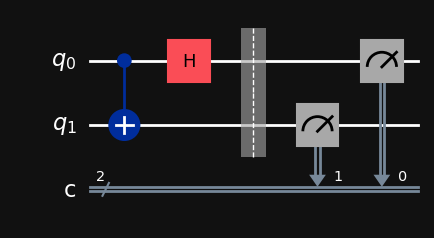

In [76]:
bellmeasure = QuantumCircuit(2,2)
bellmeasure.cx(0,1)
bellmeasure.h(0)
bellmeasure.barrier()
bellmeasure.measure(1,1)
bellmeasure.measure(0,0)
bellmeasure.draw("mpl", style = my_style)

In [81]:
simulator = Aer.get_backend('qasm_simulator')
result = simulator.run(bellmeasure).result()
counts = result.get_counts(bellmeasure)
print(counts)

{'00': 523, '01': 501}


V tomto obvodu provádíme měření ve standartní bázi. Každý Bellův stav na vstupu obvodu odpovídá jednomu vektoru standartní báze.

### Measure in Pauli bases


A measurement projects the qubit state to the computational basis 
{
∣
0
⟩
,
∣
1
⟩
}
{∣0⟩,∣1⟩}. This implies that you can only measure observables that are diagonal in this basis, such as Paulis consisting only of 
𝐼
I and 
𝑍
Z terms. Measuring arbitrary Pauli terms therefore requires a change of basis to diagonalize them. To do this, perform the following transformations, 

$$
\begin{align}
X \rightarrow Z & = HXH \\
Y \rightarrow Z & = HS^*YSH
\end{align}
$$

where H is tha Hadamard gate and $S = \sqrt{Z}$ is sometimes referred to as the phase gate. If you are using an Estimator to compute expectation values, the basis transformations are automatically performed.

Below is an example demonstrating how to prepare a quantum circuit and manually measure the qubit 0 in the X basis, qubit 1 in the Y basis and qubit 2 in the Z basis. We apply the transformations shown in the previous equation and obtain the following circuit:

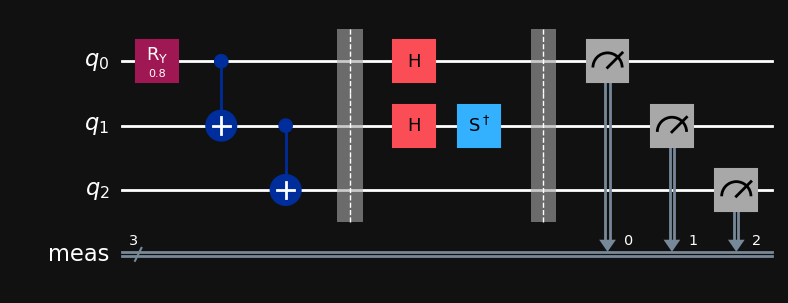

In [4]:
from qiskit.circuit import QuantumCircuit
 
# create a circuit, where we would like to measure
# q0 in the X basis, q1 in the Y basis and q2 in the Z basis
circuit = QuantumCircuit(3)
circuit.ry(0.8, 0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.barrier()
 
# diagonalize X with the Hadamard gate 
circuit.h(0)
 
# diagonalize Y with Hadamard as S^\dagger
circuit.h(1)
circuit.sdg(1)
 
# the Z basis is the default, no action required here
 
# measure all qubits
circuit.measure_all()
circuit.draw("mpl", style = my_style)

## Pauliho matice

Pro účely kvantových obvodů je užitečné (v mnoha případech i nezbytné) vyjádřit pozorovatelné pomocí tzv. Pauliho operátorů (matic). Pomocí těchto matic dokážeme vyjádřit libovolnou pozorovatelnou, a navíc pro ně známe transformační matice $X$. 

$$
\sigma_x =
\begin{pmatrix}0&1\\1&0\end{pmatrix}, \quad
\sigma_y =
\begin{pmatrix}0&-i\\i&0\end{pmatrix}, \quad
\sigma_z =
\begin{pmatrix}1&0\\0&-1\end{pmatrix} 
$$

Pauliho matice tvoří spolu s jednotkovou maticí bázi prostoru všech pozorovatelných pro jeden qbit. Jejich tenzorovým součinem lze dostat libovolnou pozorovatelnou pro více qbitů. 

Pozorovatelné dané Pauliho maticemi jsme schopni snadno měřit ve standardní bázi, jelikož známe diagonalizační matice.

### $\sigma_z$

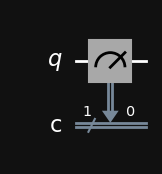

In [3]:
circuit = QuantumCircuit(1,1)
circuit.measure(0,0)
circuit.draw("mpl", style=my_style)

### $\sigma_y$

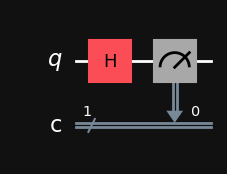

In [4]:
circuit = QuantumCircuit(1,1)
circuit.h(0)
circuit.measure(0,0)
circuit.draw("mpl", style=my_style)

### $\sigma_x$

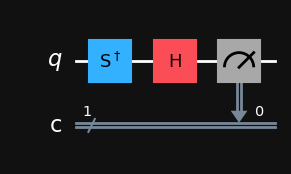

In [5]:
circuit = QuantumCircuit(1,1)
circuit.sdg(0)
circuit.h(0)
circuit.measure(0,0)

circuit.draw("mpl", style=my_style)

## Variační teorém

In quantum mechanics, energy comes in the form of a quantum observable usually referred to as the _Hamiltonian_, which we'll denote by $\hat{\mathcal{H}}$. Let us consider its [spectral decomposition](gloss:decomposition): 

$$
\hat{\mathcal{H}} = \sum_{k=0}^{N-1} \lambda_k |\phi_k\rangle \langle \phi_k|
$$

where $N$ is the dimensionality of the space of states, $\lambda_{k}$ is the $k$-th eigenvalue or, physically, the $k$-th energy level, and $|\phi_k\rangle$ is the corresponding [eigenstate](gloss:eigenstate): $\hat{\mathcal{H}}|\phi_k\rangle = \lambda_k |\phi_k\rangle$, the expected energy of a system in the (normalized) state $|\psi\rangle$ will be:

$$
\begin{aligned}
\langle \psi | \hat{\mathcal{H}} | \psi \rangle
& = \langle \psi |\bigg(\sum_{k=0}^{N-1} \lambda_k |\phi_k\rangle \langle \phi_k|\bigg) | \psi \rangle \\[1mm]
& = \sum_{k=0}^{N-1} \lambda_k \langle \psi |\phi_k\rangle \langle \phi_k| \psi \rangle \\[1mm]
& = \sum_{k=0}^{N-1} \lambda_k |\langle \psi |\phi_k\rangle|^2 \\[1mm]
\end{aligned}
$$


If we take into account that $\lambda_0\leq \lambda_k, \forall k$, we have:

$$
\begin{aligned}
\langle \psi | \hat{\mathcal{H}} | \psi \rangle
& = \sum_{k=0}^{N-1} \lambda_k |\langle \psi |\phi_k\rangle|^2 \\[1mm]
& \geq  \sum_{k=0}^{N-1} \lambda_0 |\langle \psi |\phi_k\rangle|^2 \\[1mm]
& = \lambda_0 \sum_{k=0}^{N-1} |\langle \psi |\phi_k\rangle|^2 \\[1mm]
& = \lambda_0 \\[1mm]
\end{aligned}
$$

Tudíž pro libovolný stav $\ket{\psi}$ platí:
$$
\langle \psi | \hat{\mathcal{H}} | \psi \rangle \geq \lambda_0.
$$

Hledání základního stavu $\hat{\mathcal{H}}$ s vlastním číslem $\lambda_0$ můžeme tedy převést na optimalizační úlohu:
$$
\min_{\vec\theta} C(\vec\theta) = 
\min_{\vec\theta} \langle \psi(\vec\theta)|\hat{\mathcal{H}}|\psi(\vec\theta)\rangle \geq \lambda_0.
$$

## VQE

Chceme najít stav $\ket{\psi}$ hamiltoniánu $H$, který co nejlépe aproximuje základní vlastní stav $\ket{\psi_0}$ odpovídající vlastní hodnotě $\lambda_0$. Stav $\ket{\psi}$ parametrizujeme vektorem parametrů $\vec\theta$, tyto parametry budeme optimalizovat do té doby, než se dostatečně přiblížíme základnímu stavu.

Minimalizujeme tedy funkci $C(\vec\theta) = \swch{\psi(\vec \theta)}{H}{\psi(\vec \theta)}$ optimalizací $\vec \theta$, tato funkce bývá často nazývána cost function. (Váhová funkce?)

Stav $\ket{\psi(\vec \theta)}$ s fixním $\vec \theta$ nazýváme ansatz.

![image](VQE_diagram.png)

![graph of f(theta) against theta, multiple dots show different states of a gradient descent algorithm finding the minimum of a curve.](optimization_gradient_descent.png)

## Reprezentace Hamiltoniánu

# VQE - Implementace